##Loading Files from drive
The command below is to load files from drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing Libraries
Numpy, Pandas, Torch, PIL, Torchvision, matplotlib and os libraries are imported

In [0]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

##Dataset loading
The dataset class is inherited and customized as per the dataset given. RandomResizedCrop, RandomHorizontalFlip are used as data augmentation techniques. The dataset is also normalized to obtain better results.



In [0]:
class DataSet(Dataset):
    def __init__(self, root_dir, total_no, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.total_no = total_no
        self.csv_file = np.array(pd.read_csv(csv_file, header=None))[0]

    def __len__(self):
        return self.total_no

    def __getitem__(self, image_no):
        img_name = os.path.join(self.root_dir, str(image_no+1)+".jpg")
        image = Image.open(img_name)
        sample = {'image': image, 'category': self.csv_file[image_no]-1}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample
  
trainDataset = DataSet('/content/drive/My Drive/HW3_data/train/', 
                       1888,
                       '/content/drive/My Drive/HW3_data/train_labels.csv', 
                       transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
testDataset = DataSet('/content/drive/My Drive/HW3_data/test/', 800, 
                      '/content/drive/My Drive/HW3_data/test_labels.csv', 
                      transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))

##Dataloaders for loading the datasets defined
Train and test dataloaders are defined with batch size 4, number of workers 4 and shuffling while loading data has been enabled.

In [0]:
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=4, 
                                              shuffle=True, num_workers=4)
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=4, 
                                             shuffle=True, num_workers=4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Displaying the images
The images are displayed along with their classes after loading data

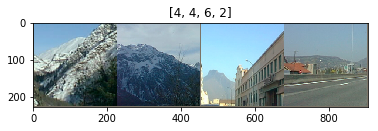

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
inputs = next(iter(trainDataloader))
out = torchvision.utils.make_grid(inputs['image'])
imshow(out, title=[int(x) for x in inputs['category']])


##Loading pretrained Alexnet model


In [0]:
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [00:08, 27452845.75it/s]


##Transfer Learning and Fine-tuning
All the layers are freezed except the final layer and the number of outputs in final layer is changed to 8.

In [0]:
for param in alexnet.parameters():
  param.requires_grad=False
alexnet.classifier[6] = torch.nn.Linear(alexnet.classifier[6].in_features, 8)

##Final Alexnet model

In [0]:
alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

##Defining Optimizer, Loss functions and Learning rate scheduler
The optimizer function, loss function and the learning rate scheduler are defined in the following segment of code.

In [0]:
Loss = torch.nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(Optimizer, step_size=7, gamma=0.1)

##Function for running the defined model
The function is defined for loading the data for each epoch, outputing the output for the batch and performing backpropagation using the defined optimizer.

In [0]:
def run_model(model, epochs, loss, optimizer, trainDataloader, testDataloader):
  model.to(device)
  for epoch in range(epochs):
    current_loss = 0.0
    exp_lr_scheduler.step()
    for i, data in enumerate(trainDataloader, 0):
      images, labels = data['image'], data['category']
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      obtained_outputs = model(images)
      obtained_loss = loss(obtained_outputs, labels)
      obtained_loss.backward()
      optimizer.step()
      current_loss += obtained_loss.item()
      if(i%100 == 99):
        print("EPOCH:", epoch+1)
        print("BATCH:", i+1)
        print("LOSS:", current_loss/100)
        print("----------------------------")
        current_loss = 0.0
  print("Training Done!!!")
  model.to(device)
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testDataloader:
      images, labels = data['image'], data['category']
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      predicted_output = torch.argmax(outputs, 1)
      correct += (predicted_output == labels).sum().item()
      total += labels.size(0)
  print("Accuracy:", correct*100/total, "%")

##Running the model
Resnet model is run for 200 epochs with the defined Cross Entropy Loss and Adam Optimizer.

In [0]:
run_model(alexnet, 200, Loss, Optimizer, trainDataloader, testDataloader)

##Training Accuracy
The trained model is run on the train dataset. Accuracy of 93.432% is obtained.

In [0]:
correct = 0
total = 0
with torch.no_grad():
  for data in trainDataloader:
    images, labels = data['image'], data['category']
    images, labels = images.to(device), labels.to(device)
    outputs = alexnet(images)
    predicted_output = torch.argmax(outputs, 1)
    correct += (predicted_output == labels).sum().item()
    total += labels.size(0)
print("Training Accuracy:", correct*100/total, "%")

Training Accuracy: 93.4322033898305 %


## Testing Accuracy
The trained model is run on the test dataset. Accuracy of 93.25% is obtained.

In [0]:
alexnet.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in testDataloader:
      images, labels = data['image'], data['category']
      images, labels = images.to(device), labels.to(device)
      outputs = alexnet(images)
      predicted_output = torch.argmax(outputs, 1)
      correct += (predicted_output == labels).sum().item()
      total += labels.size(0)
    print("Test Accuracy:", correct*100/total, "%")

Test Accuracy: 93.25 %
